<a href="https://colab.research.google.com/github/zhaoxjmail/Abnormal-check/blob/master/%5BHands_On%5D_Exploring_Gating_Mechanisms_in_Modern_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hands-On] Exploring Gating Mechanisms in Modern Transformers


- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

**Copyright**: All rights reserved

---

In this hands-on tutorial, we will explore the workings of activation functions like Sigmoid and Swish, alongside simple and implicit gating mechanisms in neural networks. The goal is to understand how these techniques can be used to selectively retain or suppress certain dimensions of the data and how they play a critical role in the structure of advanced models like LLaMA.


 ## Objectives
- Explore explicit and implicit gating mechanisms using activation functions.
- Learn about up/down projection techniques used in modern architectures such as LLaMA.



## Review : Linear Projection in PyTorch

In [ ]:
import torch
import torch.nn as nn

# Create a linear layer without bias
linear_layer = nn.Linear(in_features=4, out_features=3, bias=False)

# Example input (batch of size 2 with 4 features each)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0],
                  [5.0, 6.0, 7.0, 8.0]])

print("Input shape : ", x.shape)
print("-"*20)

# Get the weight matrix of the linear layer
W = linear_layer.weight  # Shape: [3, 4]
print('Weights : ')
print(W)
print("-"*20)

# Perform the linear projection manually
y_manual = torch.matmul(x, W.T)  # W.T because nn.Linear does W^T * x

# Or simply use the linear layer's forward pass
y_layer = linear_layer(x)

print("Manual projection result:\n", y_manual)
print("-"*20)
print("Layer projection result:\n", y_layer)


Input shape :  torch.Size([2, 4])
--------------------
Weights : 
Parameter containing:
tensor([[-0.3170,  0.4321,  0.3790, -0.2716],
        [ 0.1132,  0.3058,  0.0468, -0.1366],
        [ 0.4367, -0.3288,  0.4486, -0.0797]], requires_grad=True)
--------------------
Manual projection result:
 tensor([[0.5978, 0.3190, 0.8060],
        [1.4878, 1.6360, 2.7130]], grad_fn=<MmBackward0>)
--------------------
Layer projection result:
 tensor([[0.5978, 0.3190, 0.8060],
        [1.4878, 1.6360, 2.7130]], grad_fn=<MmBackward0>)


In PyTorch, the typical input $x$ is a row vector with shape $[\text{batch_size}, \text{in_features}]$, and the weight matrix $W$ has the shape $[\text{out_features}, \text{in_features}]$.

The internal operation transposes the weight matrix $W$ to $W^T$ (shape $[\text{in_features}, \text{out_features}]$) and performs the matrix multiplication as:

$$
y = x \times W^T
$$


## Gating | Simple Approach – Filtering Out with a Gate Vector

We will implement a simple gating mechanism where certain dimensions are manually suppressed using a gate vector. This shows how gating can control which dimensions of the output are retained or suppressed.

In [ ]:
import torch

# Input vector (1x4)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])  # Row vector simulating a batch of size 1

# Manually set W1 (without bias) to compute the output (4x4)
W1 = torch.tensor([[0.2, -0.1, 0.4, 0.5],
                   [0.3, 0.6, -0.2, 0.1],
                   [-0.3, 0.2, 0.7, 0.8],
                   [0.5, -0.4, 0.1, 0.3]])  # [4x4]

# Perform matrix multiplication with W1.T
output = torch.matmul(x, W1.T)  # [1x4] x [4x4] = [1x4]
print("Output after fc1:", output)

# Manually set the gate values for simplicity: suppress 1st and 3rd dimensions
gate = torch.tensor([[0., 1., 0., 1.]])  # Row vector as the gate
print("Gate manually set:", gate)

# Compute the final output (gated output)
final_output = output * gate # element-wise multiplication
print("Gated output:", final_output)


Output after fc1: tensor([[3.2000, 1.3000, 5.4000, 1.2000]])
Gate manually set: tensor([[0., 1., 0., 1.]])
Gated output: tensor([[0.0000, 1.3000, 0.0000, 1.2000]])


## Explicit Gating with the Sigmoid Function

This section demonstrates explicit gating using the Sigmoid function. We apply the sigmoid function to the raw output of a layer to decide which parts of the data are retained and which are suppressed.


### Sigmoid Function:
The sigmoid function is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

- It takes any real-valued number and transforms it into a value between 0 and 1.
- When the input is very large and positive, the output approaches 1.
- When the input is very large and negative, the output approaches 0.
- The midpoint (when the input is 0) is 0.5.


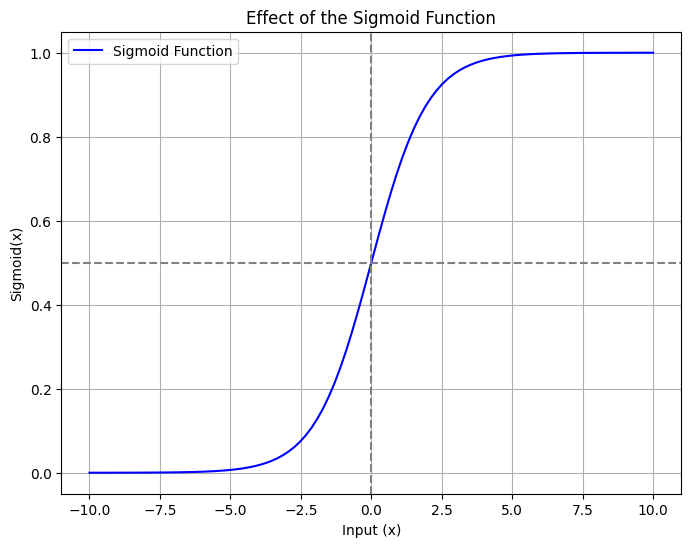

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create a range of values from -10 to 10
x_values = torch.linspace(-10, 10, 100)

# Apply the sigmoid function
sigmoid_values = torch.sigmoid(x_values)

# Create a plot to visualize the sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(x_values.numpy(), sigmoid_values.numpy(), label="Sigmoid Function", color="blue")
plt.title("Effect of the Sigmoid Function")
plt.xlabel("Input (x)")
plt.ylabel("Sigmoid(x)")
plt.grid(True)
plt.axvline(0, color='gray', linestyle='--')  # Add a vertical line at x=0
plt.axhline(0.5, color='gray', linestyle='--')  # Add a horizontal line at y=0.5
plt.legend()
plt.show()


In [ ]:
import torch

# Input vector as a row vector (1x4)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])  # [1x4], simulating a batch of 1 input vector

# Manually set W1 (without bias) to compute the output (4x4)
W1 = torch.tensor([[0.2, -0.1, 0.4, 0.5],
                   [0.3, 0.6, -0.2, 0.1],
                   [-0.3, 0.2, 0.7, 0.8],
                   [0.5, -0.4, 0.1, 0.3]])  # [4x4]

# Manually set W3 for gate computation (without bias) (4x4)
W3 = torch.tensor([[-50.0, -50.0, -50.0, -50.0],  # Large negative values for suppression
                   [100.0, 100.0, 100.0, 100.0],  # Large positive values for retention
                   [-50.0, -50.0, -50.0, -50.0],
                   [100.0, 100.0, 100.0, 100.0]])  # [4x4]

# Perform matrix multiplication
output = torch.matmul(x, W1.T)  # [1x4] x [4x4] = [1x4]
print("Output after fc1:", output)

# Perform matrix multiplication
gate_raw = torch.matmul(x, W3.T)  # [1x4] x [4x4] = [1x4]
print("Gate raw computed:", gate_raw)

# Apply the sigmoid function to the gate
gate = torch.sigmoid(gate_raw)
print("Gate computed:", gate)

# Compute the final output (element-wise multiplication between output and gate)
final_output = output * gate
print("Gated output:", final_output)


Output after fc1: tensor([[3.2000, 1.3000, 5.4000, 1.2000]])
Gate raw computed: tensor([[-500., 1000., -500., 1000.]])
Gate computed: tensor([[0., 1., 0., 1.]])
Gated output: tensor([[0.0000, 1.3000, 0.0000, 1.2000]])


- When `gate_raw` is passed through the sigmoid function to create the `gate` vector:
  - The values you want to **filter out** should result in values close to **0** after passing through the sigmoid function.
  - The values you want to **retain** should result in values close to **1** after passing through the sigmoid function.

- Roughly:
  - If an element of `gate_raw` is **less than -5**, the sigmoid output (i.e., the `gate` value) will be close to **0**, resulting in filtering out that dimension.
  - If an element of `gate_raw` is **greater than 5**, the sigmoid output (i.e., the `gate` value) will be close to **1**, retaining that dimension.

- In summary:
  - **For `gate_raw` values less than -5**, the corresponding `gate` (after applying sigmoid) will be close to 0, effectively filtering out that dimension.
  - **For `gate_raw` values greater than 5**, the corresponding `gate` will be close to 1, ensuring that the dimension is retained.


## Implicit Gating Using SiLU (Swish)

Implicit gating involves the use of an activation function, such as SiLU (also known as Swish), which automatically modulates the output without requiring an explicit gate. We explore how SiLU acts as a soft gating mechanism by applying it to linear projections.

In [ ]:
import torch

# Manual SiLU implementation
def silu(x):
    return x * (1 / (1 + torch.exp(-x)))  # SiLU formula: x * sigmoid(x)

# Input vector as a row vector (1x4)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])  # [1x4], simulating a batch of 1 input vector

# Adjusted W1 to suppress 1st and 3rd dimensions (reduce values in those rows)
W1 = torch.tensor([[0.01, -0.01, 0.02, 0.03],  # 1st row: small values for suppression
                   [0.3, 0.6, -0.2, 0.1],
                   [0.01, -0.02, 0.02, 0.03],  # 3rd row: small values for suppression
                   [0.5, -0.4, 0.1, 0.3]])

# Adjusted W3 to further suppress 1st and 3rd dimensions
W3 = torch.tensor([[0.01, 0.02, -0.01, 0.02],  # 1st row: small values for suppression
                   [0.6, 0.3, -0.1, 0.4],
                   [0.01, -0.01, 0.02, 0.01],  # 3rd row: small values for suppression
                   [0.1, 0.8, 0.4, -0.5]])

# Perform matrix multiplication using W1
output = torch.matmul(x, W1.T)  # [1x4] x [4x4] = [1x4]
print("Output after W1:", output)

# Apply the custom SiLU function
modulated_output = silu(output)  # Manually applied SiLU function
print("Output after SiLU (manually applied):", modulated_output)

# Perform a second linear transformation using W3
gate_output = torch.matmul(x, W3.T)  # [1x4] x [4x4] = [1x4]
print("Gate output from W3:", gate_output)

# Element-wise multiplication to modulate the final output
final_output = modulated_output * gate_output  # Implicit gating with SiLU-modulated output
print("Final output after implicit gating:", final_output)


Output after W1: tensor([[0.1700, 1.3000, 0.1500, 1.2000]])
Output after SiLU (manually applied): tensor([[0.0922, 1.0216, 0.0806, 0.9222]])
Gate output from W3: tensor([[0.1000, 2.5000, 0.0900, 0.9000]])
Final output after implicit gating: tensor([[0.0092, 2.5540, 0.0073, 0.8300]])


-----

## LLaMA-Style Gating with Activation and Up/Down Projection

In this section, we simulate the up/down projection technique used in LLaMA-style models. We'll manually implement a system where a lower-dimensional input is projected to a higher-dimensional space, modulated by gating mechanisms, and then projected back to its original size.


In [ ]:
import torch

# Manual SiLU implementation
def silu(x):
    return x * torch.sigmoid(x)  # SiLU formula: x * sigmoid(x)

# Input vector as a row vector (1x2)
x = torch.tensor([[1.0, 2.0]])  # [1x2], batch of 1 input vector

# Up Projection: W1 (2D to 4D)
W1 = torch.tensor([[0.2, -0.1],
                   [0.3, 0.6],
                   [-0.3, 0.2],
                   [0.5, -0.4]])  # [4x2], projecting from 2D to 4D

# Gate Projection: W3 (2D to 4D)
W3 = torch.tensor([[0.5, 0.2],
                   [0.6, 0.3],
                   [-0.4, 0.7],
                   [0.1, 0.8]])  # [4x2]

# Down Projection: W2 (4D back to 2D)
W2 = torch.tensor([[0.7, -0.5, 0.3, 0.4],
                   [-0.2, 0.8, -0.6, 0.1]])  # [2x4], projecting from 4D to 2D

# 1. Up Projection: Move x from 2D to 4D
up_projected = torch.matmul(x, W1.T)  # [1x2] x [2x4] = [1x4]
print("Up Projected Output:", up_projected)

# 2. Gate Projection: Apply W3 and SiLU activation
gate_projected = silu(torch.matmul(x, W3.T))  # SiLU applied to gate projection
print("Gate Projected Output (after SiLU):", gate_projected)

# 3. Element-wise multiplication to combine Up and Gate Projections
combined_output = up_projected * gate_projected  # Element-wise multiplication
print("Combined Output (Up * Gate):", combined_output)

# 4. Down Projection: Project the combined output back to 2D
final_output = torch.matmul(combined_output, W2.T)  # [1x4] x [4x2] = [1x2]
print("Final Output after Down Projection:", final_output)

Up Projected Output: tensor([[ 0.0000,  1.5000,  0.1000, -0.3000]])
Gate Projected Output (after SiLU): tensor([[0.6399, 0.9222, 0.7311, 1.4374]])
Combined Output (Up * Gate): tensor([[ 0.0000,  1.3833,  0.0731, -0.4312]])
Final Output after Down Projection: tensor([[-0.8422,  1.0197]])


## Conclusion

In this tutorial, we've explored the implementation of both explicit and implicit gating mechanisms, as well as the use of activation functions like ReLU and SiLU (Swish). We also demonstrated up/down projection, as seen in advanced architectures like LLaMA. By learning these techniques, you gain an understanding of how gating can be used to selectively control information flow in a neural network.